In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Users/vishn/Downloads/DATASET KAGGLE.csv")

# Filter for Product-8f75
product_df = df[df['ANONYMIZED PRODUCT'] == 'Product-8f75'].copy()

product_df['DATE'] = pd.to_datetime(product_df['DATE'], errors='coerce', dayfirst=True)

C:\Users\vishn\AppData\Local\Temp\ipykernel_16900\1447522906.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  product_df['DATE'] = pd.to_datetime(product_df['DATE'], errors='coerce', dayfirst=True)


In [10]:
import pandas as pd

# Step 1: Strip whitespace and replace known bad values
product_df['DATE'] = product_df['DATE'].astype(str).str.strip()
product_df['DATE'] = product_df['DATE'].replace(['', 'Invalid', 'NaN', 'nan'], pd.NA)

# Step 2: Parse dates safely
product_df['DATE'] = pd.to_datetime(product_df['DATE'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Step 3: Drop rows with unparseable dates
product_df = product_df[product_df['DATE'].notna()].reset_index(drop=True)

In [11]:
product_df.set_index('DATE', inplace=True)
product_df.sort_index(inplace=True)

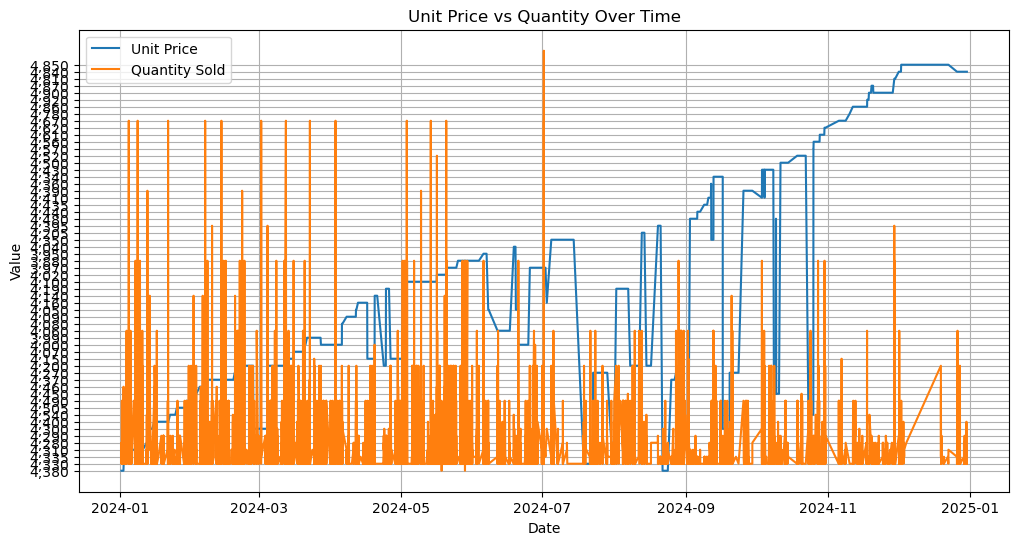

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(product_df['UNIT PRICE'], label='Unit Price')
plt.plot(product_df['QUANTITY'], label='Quantity Sold')
plt.title('Unit Price vs Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
product_df.columns = product_df.columns.str.strip().str.upper()

In [18]:
# Remove commas and convert to float
product_df['UNIT PRICE'] = product_df['UNIT PRICE'].astype(str).str.replace(',', '').astype(float)

# Now rolling mean will work
product_df['UNIT_PRICE_ROLL_MEAN'] = product_df['UNIT PRICE'].rolling(window=3).mean()

In [20]:
# Remove commas and convert to float
product_df['UNIT PRICE'] = product_df['UNIT PRICE'].astype(str).str.replace(',', '').astype(float)
product_df['QUANTITY'] = product_df['QUANTITY'].astype(str).str.replace(',', '').astype(float)

In [21]:
product_df['QUANTITY_LAG1'] = product_df['QUANTITY'].shift(1)
product_df['UNIT_PRICE_LAG1'] = product_df['UNIT PRICE'].shift(1)

product_df['QUANTITY_ROLL_MEAN'] = product_df['QUANTITY'].rolling(window=3).mean()
product_df['UNIT_PRICE_ROLL_MEAN'] = product_df['UNIT PRICE'].rolling(window=3).mean()

product_df.dropna(inplace=True)

In [22]:
from sklearn.preprocessing import MinMaxScaler

features = ['QUANTITY', 'UNIT PRICE',
            'QUANTITY_LAG1', 'UNIT_PRICE_LAG1',
            'QUANTITY_ROLL_MEAN', 'UNIT_PRICE_ROLL_MEAN']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(product_df[features])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not ha

✅ Optimized Price: ₹200.00


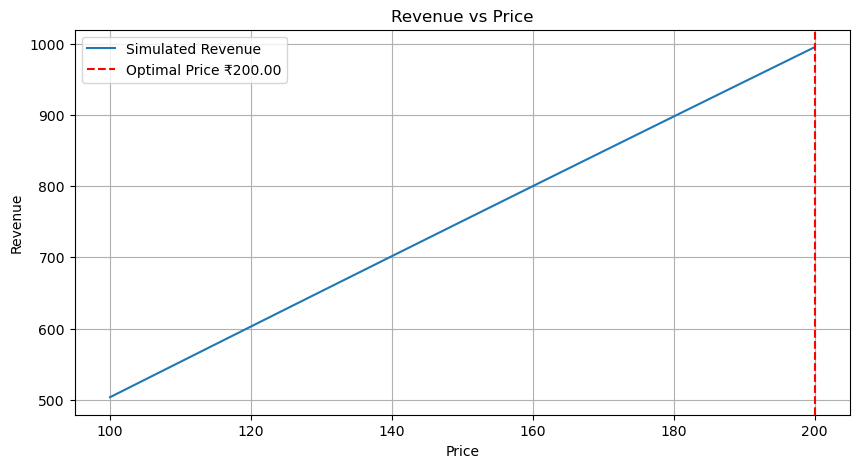

In [23]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize_scalar
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fit a demand model (Quantity vs Unit Price)
X = product_df[['UNIT PRICE']]
y = product_df['QUANTITY']
demand_model = LinearRegression().fit(X, y)

# Step 2: Define revenue function
def revenue_function(price):
    predicted_qty = demand_model.predict([[price]])[0]
    return -price * predicted_qty  # Negative for minimization

# Step 3: Optimize price using bounded scalar minimization
result = minimize_scalar(revenue_function, bounds=(100, 200), method='bounded')
optimal_price = result.x
print(f"✅ Optimized Price: ₹{optimal_price:.2f}")

# Step 4: Simulate revenue across price range
prices = np.arange(100, 201, 5)
revenues = [p * demand_model.predict([[p]])[0] for p in prices]

# Step 5: Plot revenue curve
plt.figure(figsize=(10, 5))
plt.plot(prices, revenues, label='Simulated Revenue')
plt.axvline(optimal_price, color='red', linestyle='--', label=f'Optimal Price ₹{optimal_price:.2f}')
plt.title('Revenue vs Price')
plt.xlabel('Price')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Sample structure
df = pd.DataFrame({
    'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'price': 200.0,  # constant optimized price
    'sales': np.random.randint(20, 50, size=100)  # simulated sales
})

In [25]:
from sklearn.preprocessing import MinMaxScaler

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

scaler = MinMaxScaler()
df['sales_scaled'] = scaler.fit_transform(df[['sales']])

In [26]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(df['sales_scaled'].values, window_size)

# Reshape for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, batch_size=16, verbose=1)

C:\Users\vishn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2025
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1000
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0968
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0885
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0852
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0863
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0853
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0843
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0841
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0842
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0838
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0837
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0834
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0833
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0834
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━

In [28]:
last_sequence = df['sales_scaled'].values[-window_size:]
predictions = []

for _ in range(30):
    input_seq = last_sequence.reshape((1, window_size, 1))
    pred = model.predict(input_seq)[0][0]
    predictions.append(pred)
    last_sequence = np.append(last_sequence[1:], pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

In [29]:
predicted_sales = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

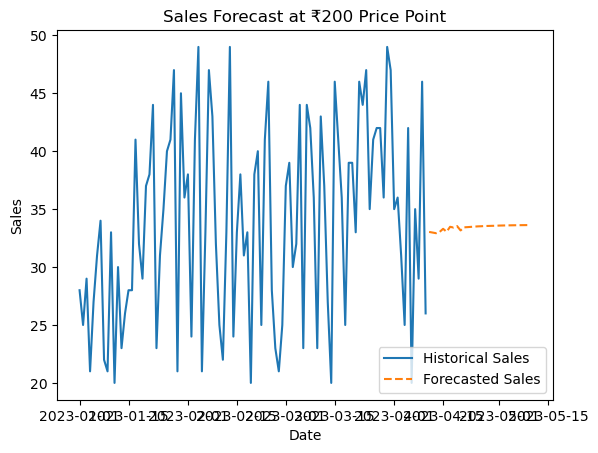

In [30]:
import matplotlib.pyplot as plt

future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(df.index, df['sales'], label='Historical Sales')
plt.plot(future_dates, predicted_sales, label='Forecasted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.title('Sales Forecast at ₹200 Price Point')
plt.show()

In [31]:
price = 200.0
revenue_forecast = predicted_sales.flatten() * price

In [32]:
import numpy as np

# Assume ±10% noise around forecast
n_simulations = 1000
simulated_revenue = []

for _ in range(n_simulations):
    noise = np.random.normal(loc=1.0, scale=0.1, size=len(revenue_forecast))
    sim = revenue_forecast * noise
    simulated_revenue.append(sim)

simulated_revenue = np.array(simulated_revenue)

In [33]:
import pandas as pd

# Calculate daily revenue totals across simulations
daily_totals = simulated_revenue.sum(axis=1)

# 5th percentile = 95% confidence VaR
VaR_95 = np.percentile(daily_totals, 5)
expected_revenue = np.mean(daily_totals)

print(f"Expected Revenue: ₹{expected_revenue:,.2f}")
print(f"Value at Risk (95%): ₹{expected_revenue - VaR_95:,.2f}")

Expected Revenue: ₹200,766.51
Value at Risk (95%): ₹5,552.08


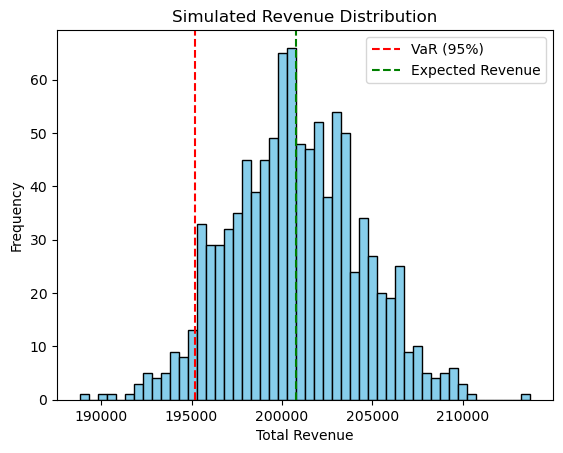

In [34]:
import matplotlib.pyplot as plt

plt.hist(daily_totals, bins=50, color='skyblue', edgecolor='black')
plt.axvline(VaR_95, color='red', linestyle='--', label='VaR (95%)')
plt.axvline(expected_revenue, color='green', linestyle='--', label='Expected Revenue')
plt.title('Simulated Revenue Distribution')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [37]:
import numpy as np
import statsmodels.api as sm

def estimate_price_elasticity(df, price_col='price', sales_col='sales'):
    df = df.copy()
    df['log_price'] = np.log(df[price_col])
    df['log_sales'] = np.log(df[sales_col])

    X = sm.add_constant(df['log_price'])
    model = sm.OLS(df['log_sales'], X).fit()

    elasticity = model.params['log_price']
    print(f"Estimated Price Elasticity: {elasticity:.2f}")
    return elasticity

In [38]:
elasticity = estimate_price_elasticity(df)

Estimated Price Elasticity: 0.66


In [39]:
def adjust_forecast_with_elasticity(predicted_sales, new_price, base_price, elasticity):
    adjustment_factor = 1 + elasticity * ((new_price - base_price) / base_price)
    adjusted_sales = predicted_sales.flatten() * adjustment_factor
    return adjusted_sales

# Apply to your forecast
adjusted_220 = adjust_forecast_with_elasticity(predicted_sales, new_price=220, base_price=200, elasticity=0.66)
adjusted_180 = adjust_forecast_with_elasticity(predicted_sales, new_price=180, base_price=200, elasticity=0.66)

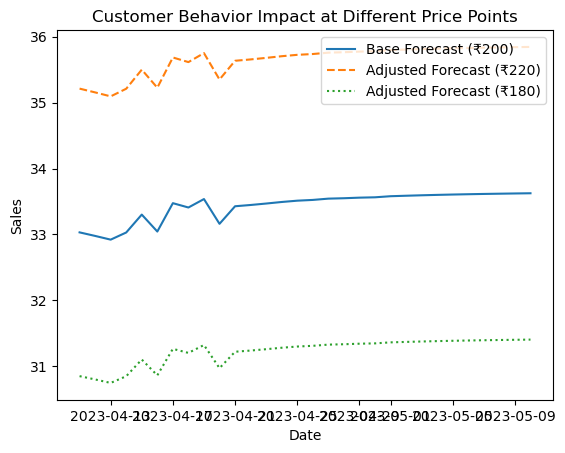

In [40]:
import matplotlib.pyplot as plt

plt.plot(future_dates, predicted_sales, label='Base Forecast (₹200)')
plt.plot(future_dates, adjusted_220, label='Adjusted Forecast (₹220)', linestyle='--')
plt.plot(future_dates, adjusted_180, label='Adjusted Forecast (₹180)', linestyle=':')
plt.title('Customer Behavior Impact at Different Price Points')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [41]:
revenue_200 = predicted_sales.flatten().sum() * 200
revenue_220 = adjusted_220.sum() * 220
revenue_180 = adjusted_180.sum() * 180

print(f"Revenue at ₹200: ₹{revenue_200:,.2f}")
print(f"Revenue at ₹220: ₹{revenue_220:,.2f}")
print(f"Revenue at ₹180: ₹{revenue_180:,.2f}")

Revenue at ₹200: ₹200,607.32
Revenue at ₹220: ₹235,232.15
Revenue at ₹180: ₹168,630.52


In [42]:
import pandas as pd

df_forecast = pd.DataFrame({
    'date': future_dates,
    'sales_200': predicted_sales.flatten(),
    'sales_220': adjusted_220,
    'sales_180': adjusted_180,
    'revenue_200': predicted_sales.flatten() * 200,
    'revenue_220': adjusted_220 * 220,
    'revenue_180': adjusted_180 * 180
})

df_forecast.to_csv('price_behavior_forecast.csv', index=False)

In [43]:
import os
print(os.getcwd())  # Shows current working directory
print(os.listdir())  # Lists all files in that directory 

C:\Users\vishn
['.anaconda', '.bash_history', '.bundle', '.cache', '.cmdstan', '.conda', '.condarc', '.config', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.local', '.matplotlib', '.vscode', 'AppData', 'Application Data', 'ayushman_bharat_tweets.csv', 'bootstrap', 'cleaned_ayushman_tweets.csv', 'Contacts', 'Cookies', 'dns_jio_output.txt', 'dns_reliance_output.txt', 'Documents', 'Downloads', 'DVWA', 'Favorites', 'finsecure_nmap_full.txt', 'finsecure_nmap_services.txt', 'GitDorker', 'go', 'jio_resolved_ips.txt', 'jio_subdomains.txt', 'Links', 'live_jio_subdomains.txt', 'live_reliance_subdomains.txt', 'live_tcs.txt', 'Local Settings', 'MAJOR PROJECT.ipynb', 'Microsoft', 'Music', 'My Documents', 'NetHood', 'nikto', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{dc766aea-f011-11ef-966f-f155c739a552}.TM.blf', 'NTUSER.DAT{dc766aea-f011-11ef-966f-f155c739a552}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{dc766aea-f011-11ef-966f-f155c739a